In [1]:
####################################################################################
#
# Joomla_Project.ipynb - script for comparing patch and schema files for Joomla project
# Copyright (C) 2023  Sravani Namburi
#
# Joomla_Project.ipynb program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 3 of the License, or
# (at your option) any later version.
# 
# Joomla_Project.ipynb program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License along
# with Joomla_Project.ipynb program; If not, see <https://www.gnu.org/licenses/>.
#
####################################################################################

In [2]:
import os
import io
import csv
import shutil
import git
import re
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import numpy as np

### Process Patch Files

In [3]:
#!/usr/bin/env python

# Process the patch files and extract the count of DDL statements, saving the results in CSV files
# Note:
#We analyzed the 4.2-dev branch, but it has been merged into the 4.4-dev branch. Currently, the 4.2-dev branch 
#is not available in the GitHub repository. Therefore, we cloned the 4.4-dev branch and excluded
#the files specific to versions 4.4 and 4.3. We then proceeded to analyze only the files from the 4.2-dev version.

#Repository clone

GITHUB_URL_Joomla = 'https://github.com/joomla/joomla-cms.git'
FOLDER_PATH_Joomla = 'Datasets/Joomla/Input/Patch_Files/Git_Joomla'


def get_repo_joomla():
    if not os.path.exists(os.path.join(os.getcwd(), FOLDER_PATH_Joomla)):
        print("Joomla Repository cloning...")
        repo = git.Repo.clone_from(GITHUB_URL_Joomla, FOLDER_PATH_Joomla)
        print("Repo cloned.")
    else:
        repo = git.Repo(FOLDER_PATH_Joomla)
        print("Existing Joomla repo used.")
    return repo



#Extract version

def get_version(filename):
    return filename.strip()[:-4]

#select Sql patters 
def sql_query():

    cmp_dct = dict()
    cmp_dct["Version"] = 0
    cmp_dct["File_Path"] = 0
    cmp_dct["Create_Table"] = 0  
    cmp_dct["Drop_Table"] = 0  
    cmp_dct["Add_Column"] = 0  
    cmp_dct["Drop_Column"] = 0  
    cmp_dct["Change_Column_Datatype"] = 0 
    cmp_dct["Rename_Table"] = 0  
    cmp_dct["Rename_Column"] = 0  
    return cmp_dct

#parse the sql statements
def sql_parse_output(cmp_dct, output):
    lines = output.split("\n")

    for line in lines:
        if "CREATE TABLE" in line.upper():
            cmp_dct["Create_Table"] += 1
        
        if "DROP TABLE" in line.upper():
            cmp_dct["Drop_Table"] += 1
           
        if line.find("ADD") != -1:
            if "ADD INDEX" not in line and "ADD KEY" not in line and "ADD UNIQUE" not in line and "changelogurl" not in line \
            and "ADD PRIMARY KEY" not in line and "ADD FOREIGN KEY" not in line \
            and "ADD  FOREIGN  KEY" not in line and "ADD CONSTRAINT" not in line and "ADD  CONSTRAINT" not in line:
                cmp_dct["Add_Column"] += line.count("ADD") 
              
        else:
            if line.find("add ") != -1:
                if "INDEX" not in line and "KEY" not in line and "UNIQUE" not in line \
                and "PRIMARY KEY" not in line and "FOREIGN KEY" not in line and "CONSTRAINT" not in line:
                    cmp_dct["Add_Column"] += 1
                   
        if "DROP" in line.upper().split():
            if "DROP TABLE" not in line.upper() and "DROP INDEX" not in line.upper() and "system_data" not in line and "invalid" not in line \
            and "DROP KEY" not in line.upper() and "DROP UNIQUE" not in line.upper() and "DROP PRIMARY KEY" not in line.upper() \
            and "DROP FOREIGN KEY" not in line.upper() and "DROP CONSTRAINT" not in line.upper() and "DROP DEFAULT" not in line.upper():
                cmp_dct["Drop_Column"] += 1
             
        if "MODIFY" in line.upper().split(): 
            cmp_dct["Change_Column_Datatype"] += 1
          
        if "RENAME" in line.upper().split():
            cmp_dct["Rename_Table"] += 1
          
        if line.find("CHANGE") != -1:
            if "CHANGE COLUMN" not in line:
                columns = line.replace("  ", " ").split("CHANGE ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                  
                    
        else:
            if "change" in line.split():
                columns = line.split("change ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                   

        if line.find("CHANGE COLUMN")  != -1:
            columns = line.split("CHANGE COLUMN ")[1].split(" ") 
            col1 = columns[0].strip("`")  
            col2 = columns[1].strip("`")  
            if col1 != col2:
                cmp_dct["Rename_Column"] += 1
            else:
                cmp_dct["Change_Column_Datatype"] += 1   
              
                
    return cmp_dct        


def list_sql(File):
    with open(File, 'r', encoding='utf8') as f:
        lines = f.readlines()
        sql_script = ' '.join([line for line in lines if not line.strip().startswith('INSERT') and \
                               not line.strip().startswith('--') and not line.strip().startswith('#') and \
                               not line.strip().startswith('##') and not line.upper().strip().startswith('INSERT') and \
                               not line.upper().strip().startswith('UPDATE') and not line.strip().startswith('VALUES') and \
                               not line.strip().startswith('(')])
        
    return sql_script

    
def Joomla():
    os.chdir('..')
    
    repo = get_repo_joomla()  
    repo.git.execute(['git', 'checkout', '4.4-dev'])
  
    sql_files=repo.git.execute(['git', 'ls-files','''*.sql'''])
    file_paths= [os.path.join("Datasets/Joomla/Input/Patch_Files/Git_Joomla",path_string) for path_string in sql_files.split('\n')]   
    file_basenames = [os.path.basename(path_string) for path_string in file_paths]
    
    # Select only .sql extension files
    sql_files1 = [f for f in repo.git.ls_files().split('\n') if f.endswith('.sql')]

    # Count the number of commits that have modified each .sql file
    rows = []
    for File in sql_files1:
        try:
            commits = list(repo.iter_commits(paths=File))
            if 'updates/mysql' not in File:
                continue
            rows.append((File, File.split('/')[-1].replace('.sql',''), len(commits)))
        except Exception as e:
            print(f"Error counting commits for file {File}: {str(e)}")
            
    with open('{}/Datasets/Joomla/Output/Joomla_Commit_Count.csv'.format(os.getcwd()), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['File_Path', 'File', 'Commit_Count'])
        writer.writerows(rows)

    # log file for each SQL file
    with open("{}/Datasets/Joomla/Output/Joomla_SQLFile_log_Info.txt".format(os.getcwd()), 'w') as f:
        for file_path in sql_files.split('\n'):
            if 'updates/mysql' not in file_path:
                continue
            log = repo.git.log(file_path)
            f.write(f'Git log for file {file_path}:\n{log}\n\n')
    
    # Extract SQL schema changes
    def schema_changes():
        findings = []
        results_dict = {"File_Path": [], "Version": [], "Create_Table": [], "Drop_Table": [], "Add_Column": [], "Drop_Column": [], "Change_Column_Datatype": [],"Rename_Table": [],"Rename_Column": []}
        for each_file, each_file_path in zip(file_basenames, file_paths):
            cmp_dct=sql_query()
            if not each_file.startswith("4"):
                continue
            if each_file.startswith("4.3"):   #skipping 4.3 version files.
                continue
            if each_file.startswith("4.4"):   #skipping 4.4 version files.
                continue
                
            if 'updates/mysql' not in each_file_path:
                continue
            version = get_version(each_file)
            cmp_dct['Version'] = version
            
            Filepath = each_file_path.strip().replace('Git_Joomla\\','')
            cmp_dct['File_Path'] = Filepath

            #output schema changes 
            results_cmp_dct = sql_parse_output(cmp_dct,list_sql(each_file_path))
            for key,value in results_cmp_dct.items():
                results_dict[key].append(value)

        df = pd.DataFrame(results_dict)
        df.loc[:,'SMOs_Total'] = df.sum(numeric_only=True, axis=1)
        df.to_csv("{}/Datasets/Joomla/Output/Joomla_MySQL_Patch_Files.csv".format(os.getcwd()),index=False)
        
    schema_changes()
    os.chdir('Code')  
  
def main():
    Joomla()

                   
if __name__ == "__main__":
   main()

Existing Joomla repo used.


In [4]:
# Merge the two dataframes (patch files smos and commit count)
os.chdir('..')
Joomla_PatchFile = pd.read_csv('{}/Datasets/Joomla/Output/Joomla_MySQL_Patch_Files.csv'.format(os.getcwd()))
Commit_Count = pd.read_csv('{}/Datasets/Joomla/Output/Joomla_Commit_Count.csv'.format(os.getcwd()))
Commit_Count = Commit_Count[['File', 'Commit_Count']]

Joomla_Merged = Joomla_PatchFile.merge(Commit_Count, left_on='Version', right_on='File', how='left')
Joomla_Merged.drop(['File'], axis=1, inplace=True)
Joomla_Merged.to_csv('{}/Datasets/Joomla/Output/Joomla_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)
os.chdir('Code')

In [5]:
Joomla_Merged

,File_Path,Version,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-03-05,0,0,0,0,1,0,0,1,7
1,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-05-15,4,0,0,0,0,0,0,4,36
2,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-07-19,1,0,0,0,1,0,0,2,10
3,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-07-29,4,18,0,1,28,0,0,51,15
4,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-08-29,0,0,0,0,8,0,0,8,6
5,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-03-09,1,0,0,0,0,0,0,1,8
6,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-03-30,0,0,2,0,1,0,0,3,5
7,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-04-15,0,0,0,0,0,0,0,0,4
8,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-04-22,0,0,0,0,5,0,0,5,5
9,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-05-20,0,0,1,0,0,0,0,1,5


In [6]:
# Add a new column for the project name

os.chdir('..')
if 'project_name' not in Joomla_Merged.columns:
    Joomla_Merged.insert(0, 'Project_Name', 'Joomla')

Joomla_Merged['Project_Name'] = Joomla_Merged['Project_Name'].fillna('Joomla')
Joomla_Merged.to_csv('{}/Datasets/Joomla/Output/Joomla_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)
os.chdir('Code')

In [7]:
Joomla_Merged

,Project_Name,File_Path,Version,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-03-05,0,0,0,0,1,0,0,1,7
1,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-05-15,4,0,0,0,0,0,0,4,36
2,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-07-19,1,0,0,0,1,0,0,2,10
3,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-07-29,4,18,0,1,28,0,0,51,15
4,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2018-08-29,0,0,0,0,8,0,0,8,6
5,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-03-09,1,0,0,0,0,0,0,1,8
6,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-03-30,0,0,2,0,1,0,0,3,5
7,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-04-15,0,0,0,0,0,0,0,0,4
8,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-04-22,0,0,0,0,5,0,0,5,5
9,Joomla,Datasets/Joomla/Input/Patch_Files/administrato...,4.0.0-2019-05-20,0,0,1,0,0,0,0,1,5


In [8]:
# Drop duplicate columns in merged dataframes

Joomla_Patch = Joomla_Merged.drop(['File_Path', 'Version'], axis=1).sum()
Joomla_Patch_df = pd.DataFrame([Joomla_Patch])
Joomla_Patch_df['Project'] = ['Joomla']
Joomla_Patch_df = Joomla_Patch_df[['Project', 'Create_Table', 'Drop_Table',  'Add_Column',  'Drop_Column', 'Change_Column_Datatype',  'Rename_Table',  'Rename_Column',  'SMOs_Total', 'Commit_Count']]
print(Joomla_Patch_df)

  Project  Create_Table  Drop_Table  Add_Column  Drop_Column  \
0  Joomla            13          19          10            5   

   Change_Column_Datatype  Rename_Table  Rename_Column  SMOs_Total  \
0                     122             1              1         171   

   Commit_Count  
0           204  


In [9]:
Joomla_Patch_df

,Project,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,Joomla,13,19,10,5,122,1,1,171,204


In [10]:
# Calculate the sum of each metric
Joomla_Patch_File = Joomla_Patch_df.drop(['Project'], axis=1).sum().astype(int)
print(Joomla_Patch_File)

Create_Table               13
Drop_Table                 19
Add_Column                 10
Drop_Column                 5
Change_Column_Datatype    122
Rename_Table                1
Rename_Column               1
SMOs_Total                171
Commit_Count              204
dtype: int32


### Database Schema File

In [11]:
# Process the database migration files, and count the DDL statements, save the output in a CSV file

os.chdir('..')
Database_MigrationFile = '{}/MySQLDiff/Output/Joomla_cmp_Schema.txt'.format(os.getcwd())
SMO_type = ["CREATE TABLE", "DROP TABLE", "RENAME", "ADD COLUMN", "DROP COLUMN", "CHANGE COLUMN", "MODIFY COLUMN"]

# Initialize lists to store data
File_Names = []
CT_nums = []
DT_nums = []
RT_nums = []
AC_nums = []
DC_nums = []
CC_nums = []
RC_nums = []
Total_nums = []

with open(Database_MigrationFile, 'r') as File:
    File_Count = {string: 0 for string in SMO_type}
    File_Name = ""
    for line in File:
        if line.startswith("Diff between"):
            if File_Count:  
                File_Names.append(File_Name)
                CT_nums.append(File_Count['CREATE TABLE'])
                DT_nums.append(File_Count['DROP TABLE'])
                RT_nums.append(File_Count['RENAME'])
                AC_nums.append(File_Count['ADD COLUMN'])
                DC_nums.append(File_Count['DROP COLUMN'])
                CC_nums.append(File_Count['CHANGE COLUMN'])
                RC_nums.append(File_Count['MODIFY COLUMN'])
                Total_nums.append(sum(File_Count.values()))
            File_Name = line.split(" and ")[0].strip().split(":")[0].split('/')[-1] + ' to ' + line.split(" and ")[1].strip().split(":")[0].split('/')[-1]
            File_Count = {string: 0 for string in SMO_type}
        else:
            for string in SMO_type:
                if string in line:
                    File_Count[string] += 1
        
    if File_Count:  
        File_Names.append(File_Name)
        CT_nums.append(File_Count['CREATE TABLE'])
        DT_nums.append(File_Count['DROP TABLE'])
        RT_nums.append(File_Count['RENAME'])
        AC_nums.append(File_Count['ADD COLUMN'])
        DC_nums.append(File_Count['DROP COLUMN'])
        CC_nums.append(File_Count['CHANGE COLUMN'])
        RC_nums.append(File_Count['MODIFY COLUMN'])
        Total_nums.append(sum(File_Count.values()))

Columns = {
    'File names': File_Names,
    'CT num': CT_nums,
    'DT num': DT_nums,
    'AC num': AC_nums,
    'DC num': DC_nums,
    'CC num': CC_nums,
    'RT num': RT_nums,
    'RC num': RC_nums,
    "SMO's_Total": Total_nums
}
Joomla_DMF_df = pd.DataFrame(Columns)


Joomla_DMF_df = Joomla_DMF_df.iloc[1:]
print(Joomla_DMF_df)
os.chdir('Code')

                                           File names  CT num  DT num  AC num  \
1   joomla_4.0.0-2018-02-24_mod.sql to joomla_4.0....       0       0       0   
2   joomla_4.0.0-2018-03-05_mod.sql to joomla_4.0....       4       0       0   
3   joomla_4.0.0-2018-05-15_mod.sql to joomla_4.0....       1       0       0   
4   joomla_4.0.0-2018-07-19_mod.sql to joomla_4.0....       2      16       7   
5   joomla_4.0.0-2018-07-29_mod.sql to joomla_4.0....       0       0       0   
6   joomla_4.0.0-2018-08-29_mod.sql to joomla_4.0....       1       0       0   
7   joomla_4.0.0-2019-03-09_mod.sql to joomla_4.0....       0       0       2   
8   joomla_4.0.0-2019-03-30_mod.sql to joomla_4.0....       0       0       0   
9   joomla_4.0.0-2019-04-15_mod.sql to joomla_4.0....       0       0       0   
10  joomla_4.0.0-2019-04-22_mod.sql to joomla_4.0....       0       0       1   
11  joomla_4.0.0-2019-05-20_mod.sql to joomla_4.0....       0       0       0   
12  joomla_4.0.0-2019-06-29_

In [12]:
# Calculate the sum of metrics
Joomla_DMF_sum_df = Joomla_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num',"SMO's_Total"]].sum()
print("Sum of Database Migration Files Metrics:")
print(Joomla_DMF_sum_df)

Sum of Database Migration Files Metrics:
CT num          12
DT num          17
AC num          17
DC num           5
CC num         130
RT num           0
RC num           0
SMO's_Total    181
dtype: int64


In [13]:
Joomla_DMF_SMO_df = Joomla_DMF_df[["SMO's_Total"]].sum()
print(Joomla_DMF_SMO_df)
print(Joomla_Patch_df["SMOs_Total"])

SMO's_Total    181
dtype: int64
0    171
Name: SMOs_Total, dtype: int64


In [14]:
print(Joomla_DMF_sum_df)
print(Joomla_Patch_File)

CT num          12
DT num          17
AC num          17
DC num           5
CC num         130
RT num           0
RC num           0
SMO's_Total    181
dtype: int64
Create_Table               13
Drop_Table                 19
Add_Column                 10
Drop_Column                 5
Change_Column_Datatype    122
Rename_Table                1
Rename_Column               1
SMOs_Total                171
Commit_Count              204
dtype: int32


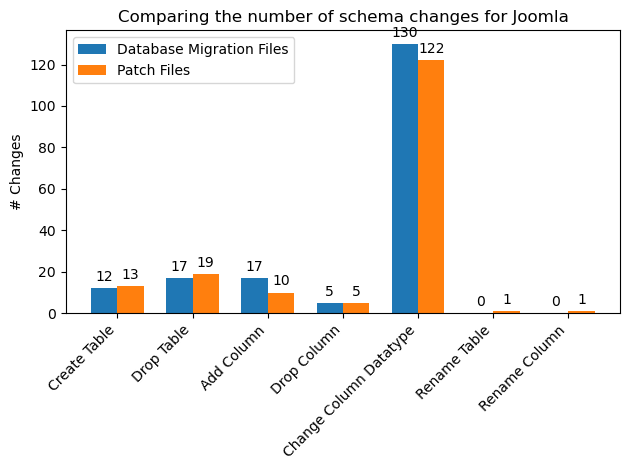

In [15]:
#Plot of Patch files and Database Migration files SMOs in the dataset


Joomla_Migration_columns = ['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']
Joomla_Migration_values = Joomla_DMF_sum_df.loc[Joomla_Migration_columns].values


if not Joomla_Patch_File.empty:
    Joomla_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
    Joomla_Patch_values = Joomla_Patch_File[Joomla_Patch_columns].values
else:
    Joomla_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
    Joomla_Patch_values = np.zeros(len(Joomla_Patch_columns))

bar_width = 0.35
index = np.arange(len(Joomla_Migration_values))
labels = ['Create Table', 'Drop Table', 'Add Column', 'Drop Column',
          'Change Column Datatype', 'Rename Table', 'Rename Column']
fig, ax = plt.subplots()
rects1 = ax.bar(index, Joomla_Migration_values, bar_width, label='Database Migration Files')
rects2 = ax.bar(index + bar_width, Joomla_Patch_values, bar_width, label='Patch Files')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('# Changes')
ax.set_title('Comparing the number of schema changes for Joomla')
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')


plt.tight_layout()
plt.show()

In [16]:
# Absolute difference and relative difference

Absolute_Difference = Joomla_Patch_File['SMOs_Total'] - Joomla_DMF_SMO_df["SMO's_Total"]
Relative_Difference = (Joomla_Patch_File['SMOs_Total'] - Joomla_DMF_SMO_df["SMO's_Total"]) / ((Joomla_Patch_File['SMOs_Total'] + Joomla_DMF_SMO_df["SMO's_Total"])/2) * 100

print("Absolute Difference:", abs(Absolute_Difference))
print("Relative Difference:", round(abs(float(Relative_Difference)), 2), "%")
print("Matching percent for Patch Files and Database Migration Files:", round(100 - round(abs(float(Relative_Difference)), 2), 2) ,"%")

Absolute Difference: 10
Relative Difference: 5.68 %
Matching percent for Patch Files and Database Migration Files: 94.32 %


In [17]:
#Absolute values and percent values

Joomla_Patch_Percent_df = Joomla_Patch_File

pattern = Joomla_Patch_Percent_df['Create_Table']  
Joomla_Patch_Percent_df['Percent_create'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Drop_Table']  
Joomla_Patch_Percent_df['Percent_drop'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Add_Column']  
Joomla_Patch_Percent_df['Percent_add'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Drop_Column']  
Joomla_Patch_Percent_df['Percent_dc'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Change_Column_Datatype']  
Joomla_Patch_Percent_df['Percent_ccd'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Rename_Table']  
Joomla_Patch_Percent_df['Percent_rt'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Joomla_Patch_Percent_df['Rename_Column']  
Joomla_Patch_Percent_df['Percent_rc'] = round((pattern / Joomla_Patch_Percent_df['SMOs_Total']) * 100,1)

print(Joomla_Patch_Percent_df)

Create_Table               13.0
Drop_Table                 19.0
Add_Column                 10.0
Drop_Column                 5.0
Change_Column_Datatype    122.0
Rename_Table                1.0
Rename_Column               1.0
SMOs_Total                171.0
Commit_Count              204.0
Percent_create              7.6
Percent_drop               11.1
Percent_add                 5.8
Percent_dc                  2.9
Percent_ccd                71.3
Percent_rt                  0.6
Percent_rc                  0.6
dtype: float64


In [18]:
# Compare CREATE table SMOs between patch files and database migration files.
Joomla_Create_Table = Joomla_Merged[['Version', 'Rename_Table', 'Create_Table']]
Joomla_DMF_CT = Joomla_DMF_df['CT num'].reset_index(drop=True)

Create_Table = pd.concat([Joomla_Create_Table, Joomla_DMF_CT], axis=1)
Create_Table['difference'] = Create_Table['Rename_Table'] + Create_Table['Create_Table'] - Create_Table['CT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Create_Table = Create_Table.style.apply(diff_val, axis=1)
Create_Table

,Version,Rename_Table,Create_Table,CT num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,4,4,0
2,4.0.0-2018-07-19,0,1,1,0
3,4.0.0-2018-07-29,0,4,2,2
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,1,1,0
6,4.0.0-2019-03-30,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0


In [19]:
# Compare DROP table SMOs between patch files and database migration files.
Joomla_Drop_Table = Joomla_Merged[['Version', 'Rename_Table', 'Drop_Table']]
Joomla_DMF_DT = Joomla_DMF_df['DT num'].reset_index(drop=True)

Drop_Table = pd.concat([Joomla_Drop_Table, Joomla_DMF_DT], axis=1)
Drop_Table['difference'] = Drop_Table['Rename_Table'] + Drop_Table['Drop_Table'] - Drop_Table['DT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Table = Drop_Table.style.apply(diff_val, axis=1)
Drop_Table

,Version,Rename_Table,Drop_Table,DT num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0
3,4.0.0-2018-07-29,0,18,16,2
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,0,0,0
6,4.0.0-2019-03-30,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0


In [20]:
# Compare ADD column SMOs between patch files and database migration files.

Joomla_Add_Column = Joomla_Merged[['Version', 'Rename_Column', 'Add_Column']]
Joomla_DMF_AC = Joomla_DMF_df['AC num'].reset_index(drop=True)

Add_Column = pd.concat([Joomla_Add_Column, Joomla_DMF_AC], axis=1)
Add_Column['difference'] = Add_Column['Rename_Column'] + Add_Column['Add_Column'] - Add_Column['AC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Add_Column = Add_Column.style.apply(diff_val, axis=1)
Add_Column

,Version,Rename_Column,Add_Column,AC num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0
3,4.0.0-2018-07-29,0,0,7,-7
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,0,0,0
6,4.0.0-2019-03-30,0,2,2,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,1,1,0


In [21]:
# Compare DROP column SMOs between patch files and database migration files.

Joomla_Drop_Column = Joomla_Merged[['Version', 'Rename_Column', 'Drop_Column']]
Joomla_DMF_DC = Joomla_DMF_df['DC num'].reset_index(drop=True)

Drop_Column = pd.concat([Joomla_Drop_Column, Joomla_DMF_DC], axis=1)
Drop_Column['difference'] = Drop_Column['Rename_Column'] + Drop_Column['Drop_Column'] - Drop_Column['DC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Column = Drop_Column.style.apply(diff_val, axis=1)
Drop_Column

,Version,Rename_Column,Drop_Column,DC num,difference
0,4.0.0-2018-03-05,0,0,0,0
1,4.0.0-2018-05-15,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0
3,4.0.0-2018-07-29,0,1,2,-1
4,4.0.0-2018-08-29,0,0,0,0
5,4.0.0-2019-03-09,0,0,0,0
6,4.0.0-2019-03-30,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0


In [22]:
# Compare CHANGE COLUMN DATATYPE SMOs between patch files and database migration files.

Joomla_Change_Column_Datatype = Joomla_Merged[['Version', 'Change_Column_Datatype']]
Joomla_DMF_CC = Joomla_DMF_df['CC num'].reset_index(drop=True)

Change_Column_Datatype = pd.concat([Joomla_Change_Column_Datatype, Joomla_DMF_CC], axis=1)
Change_Column_Datatype['difference'] =  Change_Column_Datatype['Change_Column_Datatype'] - Change_Column_Datatype['CC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Change_Column_Datatype = Change_Column_Datatype.style.apply(diff_val, axis=1)
Change_Column_Datatype

,Version,Change_Column_Datatype,CC num,difference
0,4.0.0-2018-03-05,1,1,0
1,4.0.0-2018-05-15,0,0,0
2,4.0.0-2018-07-19,1,1,0
3,4.0.0-2018-07-29,28,41,-13
4,4.0.0-2018-08-29,8,8,0
5,4.0.0-2019-03-09,0,0,0
6,4.0.0-2019-03-30,1,1,0
7,4.0.0-2019-04-15,0,0,0
8,4.0.0-2019-04-22,5,5,0
9,4.0.0-2019-05-20,0,0,0


In [23]:
# Calculate SMOs total for patch files
Joomla_Patch_SMO = Joomla_Merged[['Version', 'SMOs_Total', 'Rename_Column', 'Rename_Table']].copy()
Joomla_Patch_SMO['SMOs_Total_RTC'] = Joomla_Patch_SMO['SMOs_Total'] + Joomla_Patch_SMO['Rename_Column'] + Joomla_Patch_SMO['Rename_Table']
print(Joomla_Patch_SMO[['Version', 'SMOs_Total_RTC']])

             Version  SMOs_Total_RTC
0   4.0.0-2018-03-05               1
1   4.0.0-2018-05-15               4
2   4.0.0-2018-07-19               2
3   4.0.0-2018-07-29              51
4   4.0.0-2018-08-29               8
5   4.0.0-2019-03-09               1
6   4.0.0-2019-03-30               3
7   4.0.0-2019-04-15               0
8   4.0.0-2019-04-22               5
9   4.0.0-2019-05-20               1
10  4.0.0-2019-06-29              12
11  4.0.0-2019-07-13               1
12  4.0.0-2019-09-13               7
13  4.0.0-2019-09-22               6
14  4.0.0-2019-10-06              27
15  4.0.0-2019-10-17               3
16  4.0.0-2020-02-02               0
17  4.0.0-2020-03-10               8
18  4.0.0-2020-03-25               2
19  4.0.0-2020-05-29              25
20  4.0.0-2020-09-27               0
21  4.0.0-2020-12-20               0
22  4.0.0-2021-04-22               2
23  4.0.0-2021-04-27               0
24  4.0.0-2021-05-30               1
25  4.0.0-2021-06-04               0
2

In [24]:
# Compare total SMOs between patch files and database migration files.

Joomla_Patch_SMO = Joomla_Patch_SMO[['Version', 'SMOs_Total_RTC']]
Joomla_DMF_SMO = Joomla_DMF_df["SMO's_Total"].reset_index(drop=True)

Joomla_SMO_Merge = pd.concat([Joomla_Patch_SMO, Joomla_DMF_SMO], axis=1)
Joomla_SMO_Merge_Diff = pd.concat([Joomla_Patch_SMO, Joomla_DMF_SMO], axis=1)
Joomla_SMO_Merge_Diff['difference'] =  Joomla_SMO_Merge_Diff['SMOs_Total_RTC'] - Joomla_SMO_Merge_Diff["SMO's_Total"]

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Joomla_SMO_Merge_Diff = Joomla_SMO_Merge_Diff.style.apply(diff_val, axis=1)
Joomla_SMO_Merge_Diff

,Version,SMOs_Total_RTC,SMO's_Total,difference
0,4.0.0-2018-03-05,1,1,0
1,4.0.0-2018-05-15,4,4,0
2,4.0.0-2018-07-19,2,2,0
3,4.0.0-2018-07-29,51,68,-17
4,4.0.0-2018-08-29,8,8,0
5,4.0.0-2019-03-09,1,1,0
6,4.0.0-2019-03-30,3,3,0
7,4.0.0-2019-04-15,0,0,0
8,4.0.0-2019-04-22,5,5,0
9,4.0.0-2019-05-20,1,1,0


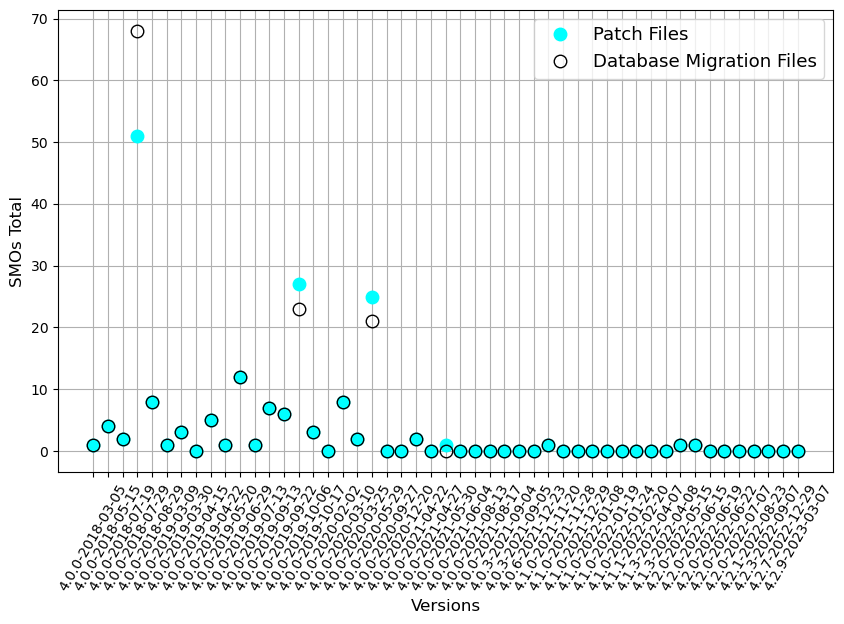

In [25]:
# Plot of Patch files and Database Migration files each version in the dataset

Joomla_Version = Joomla_Patch_SMO['Version'].str.replace('upgrade', '')  
Joomla_SMOs_Total = Joomla_Patch_SMO['SMOs_Total_RTC']

plt.figure(figsize=(10, 6)) 
plt.plot(Joomla_Version, Joomla_SMOs_Total, marker='o', color='#00FFFF', label='Patch Files', linestyle='', markersize=9)

DMF_index = Joomla_DMF_SMO.index
DMF_SMOs_Total = Joomla_DMF_SMO.values

plt.plot(DMF_index, DMF_SMOs_Total, marker='o', color='black', label="Database Migration Files", linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='black')

plt.xlabel('Versions', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.xticks(rotation=60)
plt.grid(True)
plt.legend(fontsize=13.1)

plt.show()

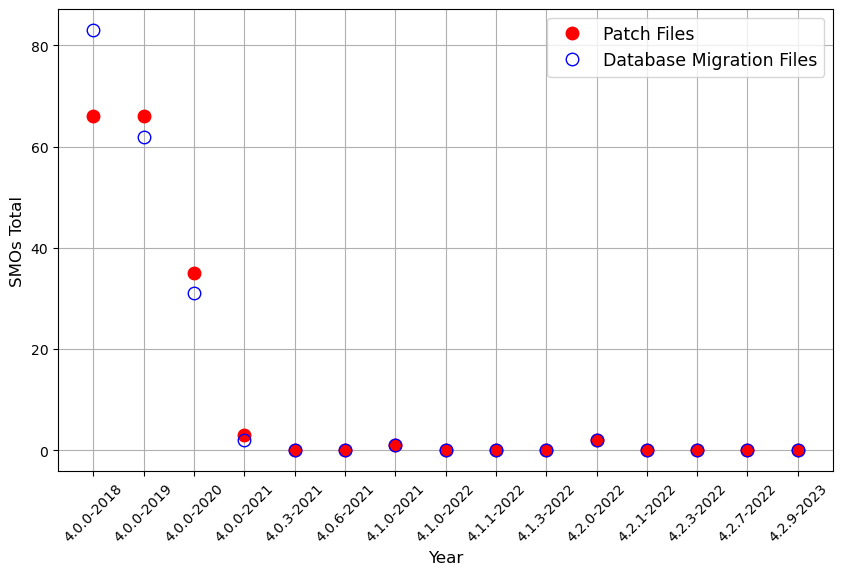

In [26]:
# Year-wise sum of SMOs

Version_Patch = Joomla_SMO_Merge['Version']
SMOs_Total_Patch = Joomla_SMO_Merge['SMOs_Total_RTC']
SMOs_Total_DMF = Joomla_SMO_Merge["SMO's_Total"]

Joomla_SMO_Merge['Version'] = Joomla_SMO_Merge['Version'].str[:10]
grouped_data = Joomla_SMO_Merge.groupby('Version').sum()
Version = grouped_data.index
SMOs_Total_Patch = grouped_data['SMOs_Total_RTC']
SMOs_Total_DMF = grouped_data["SMO's_Total"]

plt.figure(figsize=(10, 6))  
plt.plot(Version, SMOs_Total_Patch, marker='o', color='r', label='Patch Files', linestyle='', markersize=9)
plt.plot(Version, SMOs_Total_DMF, marker='o', color='b', label='Database Migration Files', linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='b')
plt.xlabel('Year', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12.5)
plt.xticks(rotation=45)

plt.show()

In [27]:
# Concatenate the two DataFrames, Extract the required columns for the table level and column level.
Joomla_Patch_df = Joomla_Merged[['Version', 'Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column', "SMOs_Total"]]
Joomla_DMF_df = Joomla_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']].reset_index(drop=True)

Joomla_Patch_DMF_df = pd.concat([Joomla_Patch_df, Joomla_DMF_df], axis=1)

Joomla_Table_df = Joomla_Patch_DMF_df[['Version', 'Create_Table', 'Rename_Table', 'CT num','Drop_Table','Rename_Table','DT num']]
Joomla_Column_df= Joomla_Patch_DMF_df[['Version', 'Add_Column', 'Rename_Column','AC num', 'Drop_Column', 'Rename_Column','DC num', 'Change_Column_Datatype', 'CC num']]

In [28]:
# Table level smos
Joomla_Table_df

,Version,Create_Table,Rename_Table,CT num,Drop_Table,Rename_Table,DT num
0,4.0.0-2018-03-05,0,0,0,0,0,0
1,4.0.0-2018-05-15,4,0,4,0,0,0
2,4.0.0-2018-07-19,1,0,1,0,0,0
3,4.0.0-2018-07-29,4,0,2,18,0,16
4,4.0.0-2018-08-29,0,0,0,0,0,0
5,4.0.0-2019-03-09,1,0,1,0,0,0
6,4.0.0-2019-03-30,0,0,0,0,0,0
7,4.0.0-2019-04-15,0,0,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0,0,0
9,4.0.0-2019-05-20,0,0,0,0,0,0


In [29]:
# Column level smos
Joomla_Column_df

,Version,Add_Column,Rename_Column,AC num,Drop_Column,Rename_Column,DC num,Change_Column_Datatype,CC num
0,4.0.0-2018-03-05,0,0,0,0,0,0,1,1
1,4.0.0-2018-05-15,0,0,0,0,0,0,0,0
2,4.0.0-2018-07-19,0,0,0,0,0,0,1,1
3,4.0.0-2018-07-29,0,0,7,1,0,2,28,41
4,4.0.0-2018-08-29,0,0,0,0,0,0,8,8
5,4.0.0-2019-03-09,0,0,0,0,0,0,0,0
6,4.0.0-2019-03-30,2,0,2,0,0,0,1,1
7,4.0.0-2019-04-15,0,0,0,0,0,0,0,0
8,4.0.0-2019-04-22,0,0,0,0,0,0,5,5
9,4.0.0-2019-05-20,1,0,1,0,0,0,0,0


In [30]:
# Extract table count and table names from database migration files.

os.chdir('..')
MigrationFiles_Path = "{}/Datasets/Joomla/Input/Migration_Files".format(os.getcwd())

File_Names = []
Table_Counts = []
Table_Names = []

for Filename in os.listdir(MigrationFiles_Path):
    if Filename.endswith('.sql'):
        File_Path = os.path.join(MigrationFiles_Path, Filename)

        with open(File_Path, 'r') as File:
            Content = File.read()
            
        DDL_Statements = Content.split(';')
        Count = 0
        Names = []

        for Statement in DDL_Statements:
            if 'CREATE TABLE' in Statement:
                Table_Name = Statement.split('CREATE TABLE')[1].split('(')[0].strip()
                Names.append(Table_Name)
                Count += 1

        File_Names.append(Filename)
        Table_Counts.append(Count)
        Table_Names.append(Names)


Column_Names = {'File Name': File_Names, 'Table_Count': Table_Counts, 'Table_Names': Table_Names}
Joomla_Table_List_df = pd.DataFrame(Column_Names)

print(Joomla_Table_List_df)

Joomla_Table_Filename = "{}/Datasets/Joomla/Output/Joomla_Databseschemafiles_table_list.csv".format(os.getcwd())
Joomla_Table_List_df.to_csv(Joomla_Table_Filename, index=False)

print("Joomla Table List saved to: {}".format(Joomla_Table_Filename))
os.chdir('Code')

                          File Name  Table_Count  \
0   joomla_4.0.0-2018-02-24_mod.sql           72   
1   joomla_4.0.0-2018-03-05_mod.sql           72   
2   joomla_4.0.0-2018-05-15_mod.sql           76   
3   joomla_4.0.0-2018-07-19_mod.sql           77   
4   joomla_4.0.0-2018-07-29_mod.sql           63   
5   joomla_4.0.0-2018-08-29_mod.sql           63   
6   joomla_4.0.0-2019-03-09_mod.sql           64   
7   joomla_4.0.0-2019-03-30_mod.sql           64   
8   joomla_4.0.0-2019-04-15_mod.sql           64   
9   joomla_4.0.0-2019-04-22_mod.sql           64   
10  joomla_4.0.0-2019-05-20_mod.sql           64   
11  joomla_4.0.0-2019-06-29_mod.sql           64   
12  joomla_4.0.0-2019-07-13_mod.sql           65   
13  joomla_4.0.0-2019-09-13_mod.sql           65   
14  joomla_4.0.0-2019-09-22_mod.sql           65   
15  joomla_4.0.0-2019-10-06_mod.sql           65   
16  joomla_4.0.0-2019-10-17_mod.sql           65   
17  joomla_4.0.0-2020-02-02_mod.sql           65   
18  joomla_4

In [31]:
# Calculate the total number of tables increased in joomla
Joomla_Total_Tables_Increased =  Joomla_Table_List_df.iloc[-1]['Table_Count'] - Joomla_Table_List_df.iloc[0]['Table_Count']
print("Total number of tables increased in Joomla: {}".format(Joomla_Total_Tables_Increased))

Total number of tables increased in Joomla: -5
